# Amazon Kindle Sentiment Analysis using LSTM

In [1]:
# importing all the necessary library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

About Data:

This Dataset is has 2 files.

The first file has 11 columns. This file is not preprocessed.

The second file has 4 columns. This is the same as above one but only contains columns that are important for Sentiment Analysis. The columns are

- Unnamed 0: we simply ignore this column
- rating: this column refers to the rating the book has recevied 
- reviewText: this column refers to the review the book has recevied 
- summray: this column referes to the summary of the book.

In [2]:
# loading our dataset

data=pd.read_csv(r"C:\Users\Purva Gawade\Downloads\preprocessed_kindle_review .csv\preprocessed_kindle_review .csv")

In [3]:
data.columns

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')

In [4]:
data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [5]:
data.tail()

,Unnamed: 0,rating,reviewText,summary
11995,11995,2,Had to read certain passages twice--typos. Wi...,Where's the meat?
11996,11996,3,Not what i expected. yet a very interesting bo...,Interesting
11997,11997,5,Dragon Knights is a world where Knights ride d...,"Dragon Knights, Wings of Change (I Dream of Dr..."
11998,11998,4,"Since this story is very short, it's hard to s...","Good writing, short story"
11999,11999,4,from 1922 an amazing collection of info on sym...,interesting public domain book


In [6]:
data.rating.value_counts()

rating
5    3000
4    3000
1    2000
3    2000
2    2000
Name: count, dtype: int64

Dropping: Summary and Unnamed 0

In [7]:
# we dont need id and summary so we will drop those columns

data=data.drop(columns=['summary','Unnamed: 0'])

In [8]:
# final look at the data

data

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."
...,...,...
11995,2,Had to read certain passages twice--typos. Wi...
11996,3,Not what i expected. yet a very interesting bo...
11997,5,Dragon Knights is a world where Knights ride d...
11998,4,"Since this story is very short, it's hard to s..."


- ###  Since rating has the value range from 1-5 we need to convert it so that we can simply the sentiment analaysis.
- ###  We will consider 1,2,3 rating as 0(negative) and 4,5 as 1(postive)

In [9]:
# Converting 1,2,3 to 0 
# Converting 4,5 to 1

data.rating=data.rating.replace([1,2,3],0)
data.rating=data.rating.replace([4,5],1)


# Checking for null values

In [10]:
data.isnull().sum()

rating        0
reviewText    0
dtype: int64

In [11]:
# final look at data
data

,rating,reviewText
0,1,This book was the very first bookmobile book I...
1,0,"When I read the description for this book, I c..."
2,1,I just had to edit this review. This book is a...
3,1,I don't normally buy 'mystery' novels because ...
4,1,"This isn't the kind of book I normally read, a..."
...,...,...
11995,0,Had to read certain passages twice--typos. Wi...
11996,0,Not what i expected. yet a very interesting bo...
11997,1,Dragon Knights is a world where Knights ride d...
11998,1,"Since this story is very short, it's hard to s..."


In [12]:
data.rating.value_counts()

rating
1    6000
0    6000
Name: count, dtype: int64

## Plotting Pie chart of the rating 

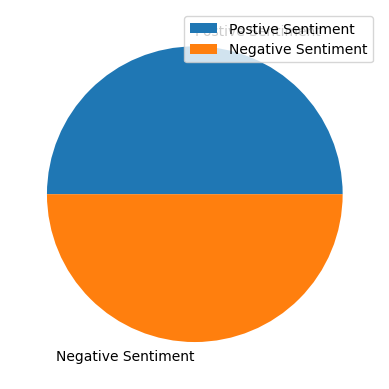

In [13]:
y = np.array([6000,6000])
mylabels = ["Postive Sentiment", "Negative Sentiment"]

plt.pie(y, labels = mylabels)
plt.legend()
plt.show() 

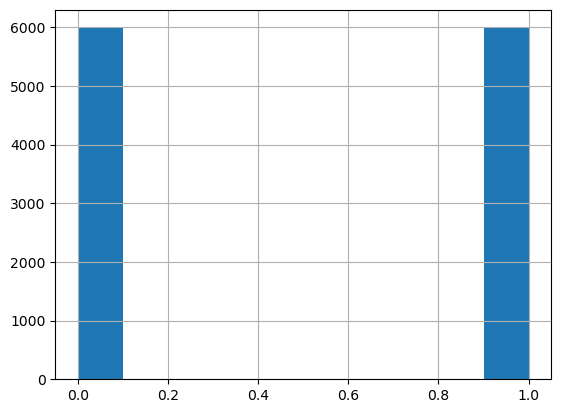

In [14]:
data.rating.hist()
plt.show()

### Selecting Data 

In [15]:
my_data=data[:8000]

In [16]:
my_data

,rating,reviewText
0,1,This book was the very first bookmobile book I...
1,0,"When I read the description for this book, I c..."
2,1,I just had to edit this review. This book is a...
3,1,I don't normally buy 'mystery' novels because ...
4,1,"This isn't the kind of book I normally read, a..."
...,...,...
7995,0,No summaries or spoilers. HIGH LEVEL: light pa...
7996,1,This is a great side story for Zsadist and Bel...
7997,1,Weekend Pick Me Up - Surviving The Fog by Stan...
7998,1,What a fun read! Phoebe is a much put upon gi...


In [17]:
my_data.rating.value_counts()

rating
0    4001
1    3999
Name: count, dtype: int64

The labels for this dataset are categorical. Machines understand only numeric data. So, convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.

In [18]:
sentiment_label = my_data.rating.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 0, 1], dtype=int64), Index([1, 0], dtype='int64'))

If you observe, the 1 here represents positive sentiment and the 0 represents negative sentiment

We should transform our text data into something that our machine learning model understands. Basically, we need to convert the text into an array of vector embeddings. Word embeddings are a beautiful way of representing the relationship between the words in the text.

To do this, we first give each of the unique words a unique number and then replace that word with the number assigned.

Let’s tokenize all the words in the text with the help of Tokenizer. In tokenization, we break down all the words/sentences of a text into small parts called tokens.

In [19]:
tweet = my_data.reviewText
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

The fit_on_texts() method creates an association between the words and the assigned numbers. This association is stored in the form of a dictionary in the tokenizer.word_index attribute.

Replace the words with their assigned numbers using the text_to_sequence() method.

Each of the sentences in the dataset is not of equal length. Use padding to pad the sentences to have equal length.

In [ ]:
#print(tokenizer.word_index)
# print(tweet[0])
# print(encoded_docs[0])
# print(padded_sequence[0])

# Building Model

In [22]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(LSTM(50, dropout=0.5)
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           873472    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 890123 (3.40 MB)
Trainable params: 890123 (3.40 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [23]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.25,epochs=10,batch_size=64)

Epoch 1/10


94/94 [==============================] - 25s 199ms/step - loss: 0.6560 - accuracy: 0.6035 - val_loss: 0.7822 - val_accuracy: 0.6415
Epoch 2/10
94/94 [==============================] - 18s 190ms/step - loss: 0.4501 - accuracy: 0.7937 - val_loss: 0.4138 - val_accuracy: 0.8220
Epoch 3/10
94/94 [==============================] - 18s 189ms/step - loss: 0.3471 - accuracy: 0.8563 - val_loss: 0.3930 - val_accuracy: 0.8250
Epoch 4/10
94/94 [==============================] - 18s 189ms/step - loss: 0.2838 - accuracy: 0.8882 - val_loss: 0.4418 - val_accuracy: 0.8140
Epoch 5/10
94/94 [==============================] - 18s 186ms/step - loss: 0.2371 - accuracy: 0.9105 - val_loss: 0.4749 - val_accuracy: 0.8205
Epoch 6/10
94/94 [==============================] - 19s 207ms/step - loss: 0.1961 - accuracy: 0.9277 - val_loss: 0.6859 - val_accuracy: 0.8020
Epoch 7/10
94/94 [==============================] - 20s 216ms/step - loss: 0.1719 - accuracy: 0.9395 - val_loss: 0.5474 - val_accuracy: 0.81

Sentiment analysis model obtained 90% accuracy on the training set and 80% accuracy on the test set.

Let’s plot these metrics using the matplotlib.

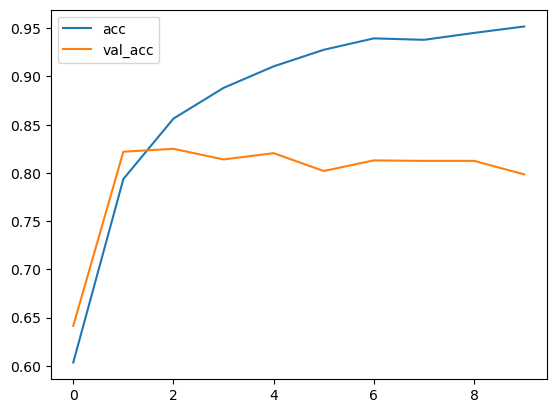

In [24]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

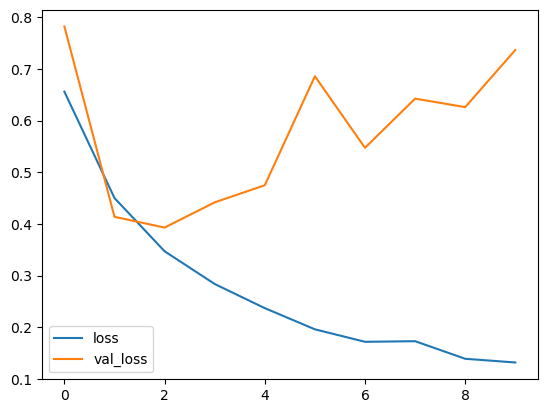

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Prediction

In [27]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    return sentiment_label[1][prediction]
    
test_sentence1 = "I like this book."
prediction = predict_sentiment(test_sentence1)

if prediction == 0:
    print("Postive Statement")
else:
    print("Negative Statement")

1/1 [==============================] - 1s 548ms/step
Postive Statement
